# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
basic_img_normalize = 0

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape)

(34799, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Text(0.5,1,'Test Data Label Histogram')

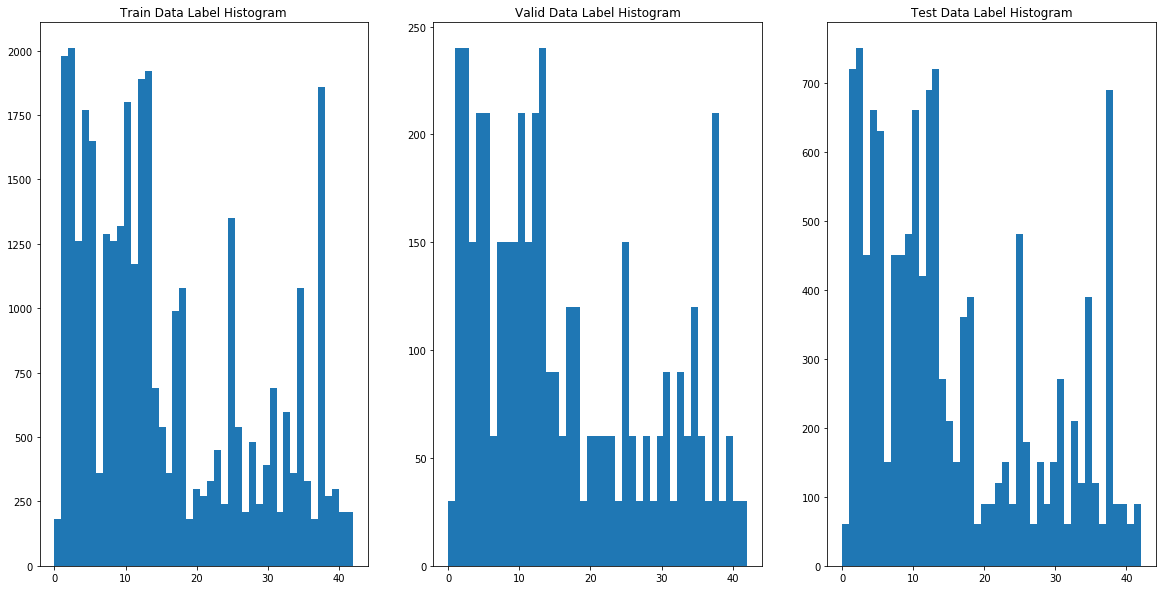

In [74]:
import matplotlib.pyplot as plt

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image?
image_shape = X_train[0].shape

# Number of labels
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 10))
ax1.hist(y_train,bins=n_classes)
ax1.set_title('Train Data Label Histogram')
ax2.hist(y_valid,bins=n_classes)
ax2.set_title('Valid Data Label Histogram')
ax3.hist(y_test,bins=n_classes)
ax3.set_title('Test Data Label Histogram')


## Step 2: Augument Training Data and Visualize

### Data Augmentation Code

In [3]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 10
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        noisy = noisy.astype(np.uint8)
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 255

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out

def rotateimg(angle, image):
    rows,cols,ch = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

### Visualizing Image, Flip, and Salt and Pepper

Text(0.5,1,'23')

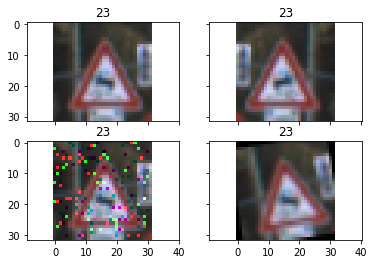

In [64]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

# Visualizations will be shown in the notebook.
%matplotlib inline

#index = random.randint(0, n_train)
index = np.where(y_train == 23)
index = int(index[0][100])
image      = X_train[index]
image_flip = np.fliplr(image)
image_salt = noisy('s&p', X_train[index])
image_rot  = rotateimg(10, X_train[index])

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex=True, sharey=True)
ax1.imshow(image)
ax1.set_title(y_train[index])
ax2.imshow(image_flip)
ax2.set_title(y_train[index])
ax3.imshow(image_salt)
ax3.set_title(y_train[index])
ax4.imshow(image_rot)
ax4.set_title(y_train[index])

### Adding Augmented Data to Training Set

In [5]:
tempX = X_train
tempy = y_train
count = 0
aug_flag = 0
if (aug_flag == 1):
    for i in range(0,len(y_train)):
        # For adding S&P noise 
        #if (y_train[i] in {0,6,14,15,16,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,36,37,39,40,41,42}):
            #tempX = np.append(tempX, noisy('s&p', X_train[i]))
            #tempy = np.append(tempy, y_train[i])
            #count += 1
        # For flipping the image along the vertical axis
        if (y_train[i] in {23, 27,30}):
        #if (y_train[i] in {11, 12, 13, 17, 23, 26, 28, 30, 35, 40}):
            tempX = np.append(tempX, np.fliplr(X_train[i]))
            tempy = np.append(tempy, y_train[i])
            count += 1
        # Add 10/-10 rotate
        if (y_train[i] in {0,6,19,20,21,22,24,27,29,32,37,39,40,41,42}):   
            tempX = np.append(tempX, rotateimg(10, X_train[i]))
            tempy = np.append(tempy, y_train[i])
            tempX = np.append(tempX, rotateimg(-10, X_train[i]))
            tempy = np.append(tempy, y_train[i])
            count += 2
        # For add 5/-5 rotate
        #if (y_train[i] in {0,16,19,24,27,28,29,32,34,36,37,41,42}):
            #tempX = np.append(tempX, rotateimg(5, X_train[i]))
            #tempy = np.append(tempy, y_train[i])
            #tempX = np.append(tempX, rotateimg(-5, X_train[i]))
            #tempy = np.append(tempy, y_train[i])
            #count += 2
        # For add 15/-15 rotate
        if (y_train[i] in {0}):   
            tempX = np.append(tempX, rotateimg(15, X_train[i]))
            tempy = np.append(tempy, y_train[i])
            tempX = np.append(tempX, rotateimg(-15, X_train[i]))
            tempy = np.append(tempy, y_train[i])
            count += 2
    tempX = tempX.reshape(X_train.shape[0]+count,X_train.shape[1],X_train.shape[2],X_train.shape[3])
    X_train_aug = tempX
    y_train_aug = tempy
    print(len(y_train_aug))
    print(count)


### Save Pickle Files

In [6]:
import os
train_aug_file = '../data/train_aug_flip_10.p'
exists = os.path.isfile(train_aug_file)
if exists:
    print('Already exists!')
else:
    print('Saving files')
    dogs_dict = {'features': X_train_aug, 'labels': y_train_aug}
    outfile = open(train_aug_file,'wb')
    pickle.dump(dogs_dict,outfile)
    outfile.close()

Already exists!


### Load Pickle Files

In [7]:
import pickle

train_aug_file = '../data/train_aug_flip_10_5.p'
infile = open(train_aug_file,'rb')
train_aug = pickle.load(infile)
infile.close()
X_train_aug, y_train_aug = train_aug['features'], train_aug['labels']
print(X_train_aug.shape)

(50369, 32, 32, 3)


In [8]:
print('The shape of the non-augemented data is' + str(X_train.shape))
z = tempX.reshape(X_train.shape[0]+count,X_train.shape[1],X_train.shape[2],X_train.shape[3])
print('The shape of the augmented data is     ' + str(X_train_aug.shape))

The shape of the non-augemented data is(34799, 32, 32, 3)
The shape of the augmented data is     (50369, 32, 32, 3)


### Histogram after adding augmentation on the training set

Text(0.5,1,'Train Aug Data Label Histogram')

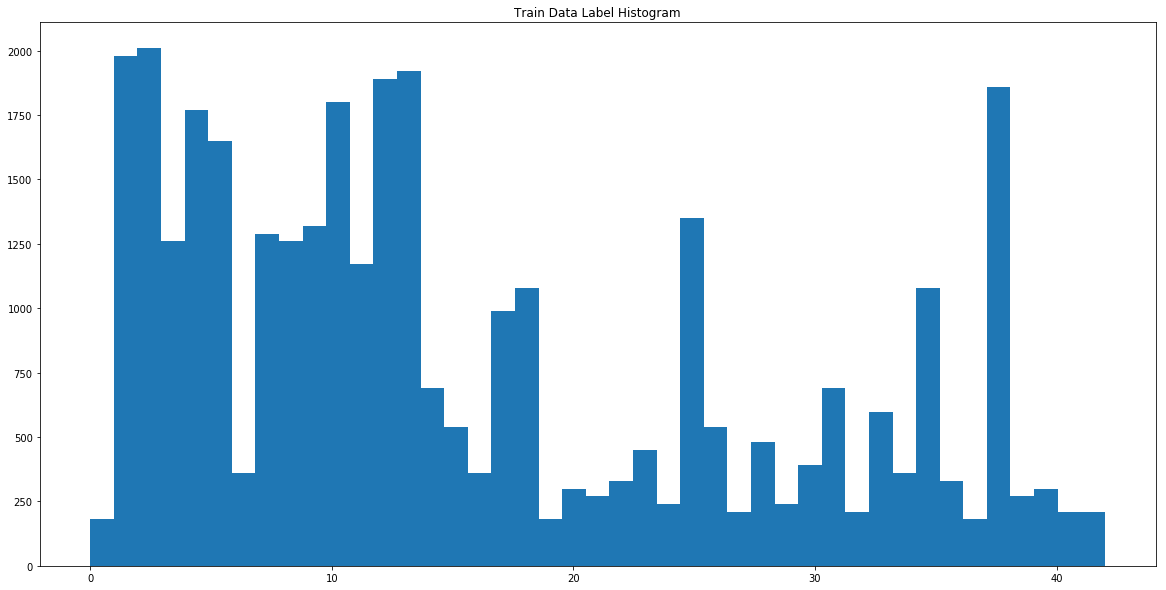

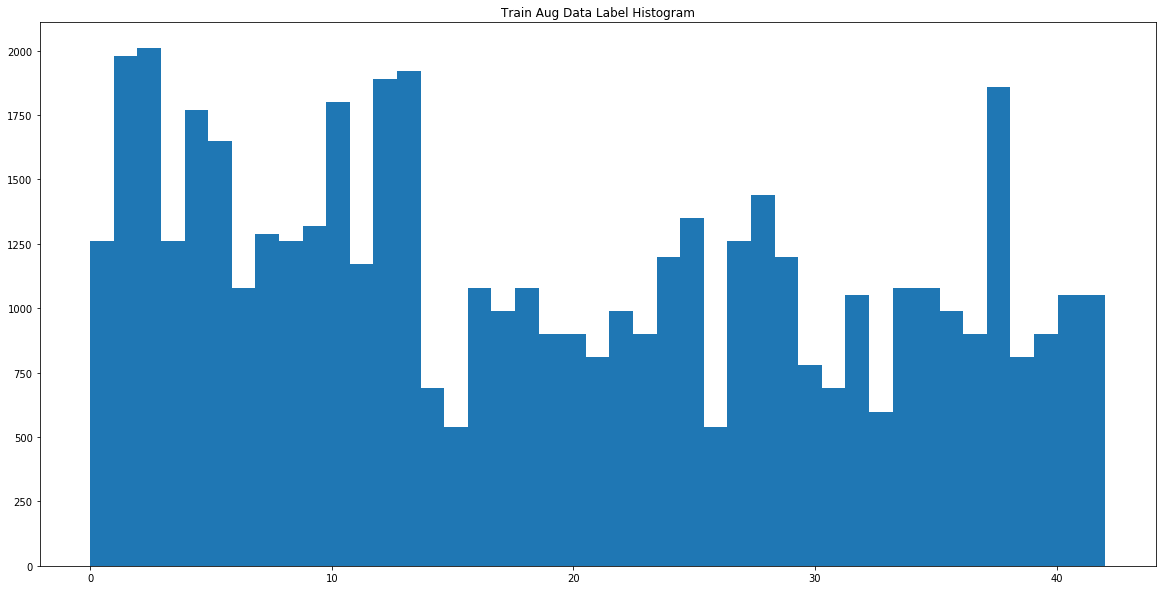

In [9]:
import matplotlib.pyplot as plt

# Number of labels
n_classes = 43

f, (ax1) = plt.subplots(1,1,figsize=(20, 10))
ax1.hist(y_train,bins=n_classes)
ax1.set_title('Train Data Label Histogram')

f, (ax2) = plt.subplots(1,1,figsize=(20, 10))
ax2.hist(y_train_aug,bins=n_classes)
ax2.set_title('Train Aug Data Label Histogram')

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
import numpy as np
import cv2

# Shuffle the training, valid data
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
X_valid, y_valid = shuffle(X_valid, y_valid)

# Convert to Grayscale
X_train_gray = np.empty_like(X_train_aug[...,:1])
for i in range(X_train_aug.shape[0]):
    X_train_gray[i,:,:,0] = cv2.cvtColor(X_train_aug[i], cv2.COLOR_RGB2GRAY)
X_valid_gray = np.empty_like(X_valid[...,:1])
for i in range(X_valid.shape[0]):
    X_valid_gray[i,:,:,0] = cv2.cvtColor(X_valid[i], cv2.COLOR_RGB2GRAY)
X_test_gray = np.empty_like(X_test[...,:1])
for i in range(X_test.shape[0]):
    X_test_gray[i,:,:,0] = cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY)

# Normalize the training, valid, test data
if (basic_img_normalize == 0):
    X_train_gray = (X_train_gray - 128.0) / 128.0
    X_valid_gray = (X_valid_gray - 128.0)/128.0
    X_test_gray = (X_test_gray - 128.0) / 128.0
    basic_img_normalize = 1
    print('running basic normalizing')
else:
    print('already ran the basic normalizing') 

y_train_gray = y_train_aug

running basic normalizing


----

## Step 3: Design and Test a Model Architecture

### Model Architecture

#### Define some of the parameters for running CNN

In [11]:
import tensorflow as tf
EPOCHS = 20
BATCH_SIZE = 128

#### Define the LeNet

In [12]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    mu = 0
    sigma = 0.1
    
    # Convolutional Layer 1: Input = 32x32x1, Output = 14x14x32
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    conv1   = tf.nn.dropout(conv1, 0.7)
    conv1   = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Convolutional Layer 2: Input = 14x14x32, Output = 5x5x64
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,32,64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = tf.nn.relu(conv2)
    conv2   = tf.nn.dropout(conv2, 0.7)
    conv2   = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten for FCs
    fc0     = flatten(conv2)
    
    # FC Layer 1: Input 1600, Output = 780
    fc1_W   = tf.Variable(tf.truncated_normal(shape=(1600,780), mean = mu, stddev = sigma))
    fc1_b   = tf.Variable(tf.zeros(780))
    fc1     = tf.matmul(fc0, fc1_W) + fc1_b
    fc1     = tf.nn.relu(fc1)
    fc1     = tf.nn.dropout(fc1, 0.7)
    
    # FC Layer 2: Input 780, Output = 360 
    fc2_W   = tf.Variable(tf.truncated_normal(shape=(780,360), mean = mu, stddev = sigma))
    fc2_b   = tf.Variable(tf.zeros(360))
    fc2     = tf.matmul(fc1, fc2_W) + fc2_b
    fc2     = tf.nn.relu(fc2)
    fc2     = tf.nn.dropout(fc2, 0.7)
    
     # FC Layer 3: Input 120, Output = 43 (n_classes) 
    fc3_W   = tf.Variable(tf.truncated_normal(shape=(360,n_classes), mean = mu, stddev = sigma))
    fc3_b   = tf.Variable(tf.zeros(n_classes))
    logits  = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Training Pipeline

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [14]:
rate               = 0.001
logits             = LeNet(x)
cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation     = tf.reduce_mean(cross_entropy)
optimizer          = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#### Model Evaluation

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Training the model
* EPOCH 20 Validation Accuracy 0.924 with (BATCH_SIZE = 128, PreProcess: Grayscale, normalize)
* EPOCH 20 Validation Accuracy 0.936 with (BATCH_SIZE = 128, PreProcess: Grayscale, normalize, 10 deg rotate)
* EPOCH 20 Valdiation Accuracy 0.939 with (BATCH_SIZE = 128,PreProcess: Grayscale, normalize, 10 deg, 5 deg)

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray, y_train_gray = shuffle(X_train_gray, y_train_gray)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train_gray[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_gray, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.820

EPOCH 2 ...
Validation Accuracy = 0.877

EPOCH 3 ...
Validation Accuracy = 0.903

EPOCH 4 ...
Validation Accuracy = 0.914

EPOCH 5 ...
Validation Accuracy = 0.921

EPOCH 6 ...
Validation Accuracy = 0.928

EPOCH 7 ...
Validation Accuracy = 0.923

EPOCH 8 ...
Validation Accuracy = 0.918

EPOCH 9 ...
Validation Accuracy = 0.932

EPOCH 10 ...
Validation Accuracy = 0.939

EPOCH 11 ...
Validation Accuracy = 0.927

EPOCH 12 ...
Validation Accuracy = 0.935

EPOCH 13 ...
Validation Accuracy = 0.934

EPOCH 14 ...
Validation Accuracy = 0.935

EPOCH 15 ...
Validation Accuracy = 0.936

EPOCH 16 ...
Validation Accuracy = 0.939

EPOCH 17 ...
Validation Accuracy = 0.940

EPOCH 18 ...
Validation Accuracy = 0.936

EPOCH 19 ...
Validation Accuracy = 0.937

EPOCH 20 ...
Validation Accuracy = 0.939

Model saved


#### Evaluate the model

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.925


---

## Step 4: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

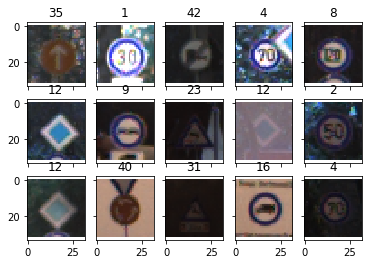

In [69]:
### Load the images and plot them here.
# row and column sharing
import os
X_final_test = []
y_final_test = np.array([35,1,42,4,8,12,9,23,12,2,12,40,31,16,4])
f, ((ax1,ax2,ax3,ax4,ax5), (ax6,ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3, 5,sharex=True, sharey=True)
index = 0
for image in os.listdir("FinalTestImages/"):
    image = cv2.imread('FinalTestImages/'+image,cv2.IMREAD_COLOR)
    eval('ax'+str(index+1)).imshow(image)
    eval('ax'+str(index+1)).set_title(str(y_final_test[index]))
    index += 1
    X_final_test = np.append(X_final_test,image)
X_final_test = X_final_test.reshape(index,32,32,3)

### Make Image into grayscale and output

In [70]:
# Convert to Grayscale
X_final_test_gray = np.empty_like(X_final_test[...,:1])
print(X_final_test.shape)    
for i in range(X_final_test.shape[0]):
    X_final_test_gray[i,:,:,0] = cv2.cvtColor(X_final_test[i].astype(np.uint8), cv2.COLOR_RGB2GRAY)
y_final_test_gray = y_final_test
print(X_final_test_gray.shape)    
print(y_final_test_gray.shape)

(15, 32, 32, 3)
(15, 32, 32, 1)
(15,)


### Predict the Sign Type for Each Image and Accuracy

In [71]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_final_test_gray, y_final_test_gray)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.600


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [72]:
def top5prob(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
    total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [73]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prob = sess.run(logits, feed_dict={x: X_final_test_gray})
    probs = sess.run(tf.nn.top_k(prob, k=5))
    print(probs)

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[  178.09257507,   126.89638519,   108.7653656 ,    88.11065674,
           58.04236221],
       [  803.17926025,   764.39300537,   563.73345947,   464.71759033,
          402.29211426],
       [  451.54495239,   368.39117432,   192.61132812,   179.55192566,
          138.51747131],
       [ 1612.17858887,  1283.04626465,  1075.5802002 ,   683.32495117,
          381.83236694],
       [ 1290.09631348,   645.73815918,   534.3973999 ,   392.22244263,
          150.08317566],
       [ 2195.40356445,   523.14208984,   434.88198853,   316.37136841,
          198.18244934],
       [ 4216.46533203,  1722.78747559,  1063.1171875 ,   774.67095947,
          768.09222412],
       [  413.60064697,   383.05325317,   311.49707031,   291.44741821,
          285.03942871],
       [  835.55877686,   722.70117188,   546.55389404,   381.80993652,
          276.49334717],
       [ 1359.95141602,   463.16802979,   290.77520752,   228.6

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 5 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [23]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")